# Machine Learning in Chess to Study Patterns in Chess Games


## Import Libraries


In [28]:
import dask.dataframe as dd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


## Load the Data


In [21]:
DATA_PATH = "/Users/isaac/Downloads/ChessDBs/lichess_db_standard_rated_2022"
# Check whether the DataFrame has been loaded correctly.
df = dd.read_parquet(DATA_PATH, engine="pyarrow")
print(f"Loaded {len(df)} Rated Bullet, Rated Blitz, and Rated Rapid games from 2022.\n")
display(df)
display(df.head())


Loaded 63927025 Rated Bullet, Rated Blitz, and Rated Rapid games from 2022.



,UTCDateTime,Event,TimeControl,Result,Termination,ECO,Opening,White,Black,WhiteElo,BlackElo,Site
npartitions=153,,,,,,,,,,,,
,datetime64[ns],category[unknown],string,category[unknown],category[unknown],string,string,string,string,int16,int16,string
,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...


,UTCDateTime,Event,TimeControl,Result,Termination,ECO,Opening,White,Black,WhiteElo,BlackElo,Site
0,2022-01-01 00:00:11,Rated Bullet game,120+1,0-1,Normal,D02,Queen's Pawn Game: Chigorin Variation,Kike73,Aox066,1255,1252,https://lichess.org/BPNsj2LF
1,2022-01-01 00:00:11,Rated Bullet game,120+1,1-0,Normal,C40,King's Pawn Game: Busch-Gass Gambit,schachueli,HiddenEyes,1346,1308,https://lichess.org/ooDjyGrm
2,2022-01-01 00:00:11,Rated Bullet game,120+1,0-1,Time forfeit,C02,"French Defense: Advance Variation, Nimzowitsch...",Renf7,Euphorbe92,859,964,https://lichess.org/T4TIdZZM
3,2022-01-01 00:00:11,Rated Bullet game,120+1,0-1,Time forfeit,B10,Caro-Kann Defense: Accelerated Panov Attack,Ralza63,FN2718,1769,1702,https://lichess.org/Oz5OFohi
4,2022-01-01 00:00:11,Rated Bullet game,120+1,1-0,Time forfeit,A41,Queen's Pawn Game,arkchess1963,sirkkeli,2146,2196,https://lichess.org/iehbAAzy


## Get Most Popular Openings


In [22]:
display(df["Opening"].value_counts().compute())


Modern Defense                                       1643325
Queen's Pawn Game                                    1636105
Scandinavian Defense: Mieses-Kotroc Variation        1400483
Caro-Kann Defense                                    1231717
Philidor Defense                                     1154531
                                                      ...   
Queen's Gambit Accepted: Alekhine Defense, Ala...          1
King's Gambit Accepted: Bishop's Gambit, Chigo...          1
Italian Game: Evans Gambit, Göring Attack                  1
Ruy Lopez: Open, Bernstein Variation, Luther Line          1
Vienna Game: Stanley Variation, Eifel Gambit               1
Name: Opening, Length: 2997, dtype: Int64

## Get Most Popular Opening Categories


In [23]:
display(df["ECO"].value_counts().compute())


A00    3951040
A40    3527282
B01    3384668
D00    2822607
B00    2794027
        ...   
A79         53
D68         49
E96         24
D65         15
D99          1
Name: ECO, Length: 497, dtype: Int64

## Get Elo Distribution of Players


In [51]:
white_elo_count = df["WhiteElo"].value_counts().compute()
black_elo_count = df["BlackElo"].value_counts().compute()

# Merge the counts into one, as the player's side isn't important.
elo_counts = pd.concat([white_elo_count, black_elo_count], axis=1).fillna(0).astype(int)
elo_counts = elo_counts.sum(axis=1)
# Find the maximum ELO rating.
max_elo = elo_counts.index.max()
print(f"Maximum ELO rating: {max_elo}")

# Define the bin edges for ELO ratings from 600 (minimum ELO in Lichess) to the
# maximum ELO in intervals of 200.
bin_size = 200
elo_bins = np.array([i for i in range(600, max_elo + bin_size, bin_size)])
elo_counts.index = pd.cut(elo_counts.index, bins=elo_bins)
merged_elo_counts = elo_counts.groupby(level=0).sum()
display(merged_elo_counts)


Maximum ELO rating: 3485


(600, 800]       1036347
(800, 1000]      4869159
(1000, 1200]    11242416
(1200, 1400]    17564485
(1400, 1600]    23150584
(1600, 1800]    25317906
(1800, 2000]    22498480
(2000, 2200]    14115285
(2200, 2400]     5816418
(2400, 2600]     1709222
(2600, 2800]      420496
(2800, 3000]       73395
(3000, 3200]        7295
(3200, 3400]         459
(3400, 3600]           1
dtype: int64

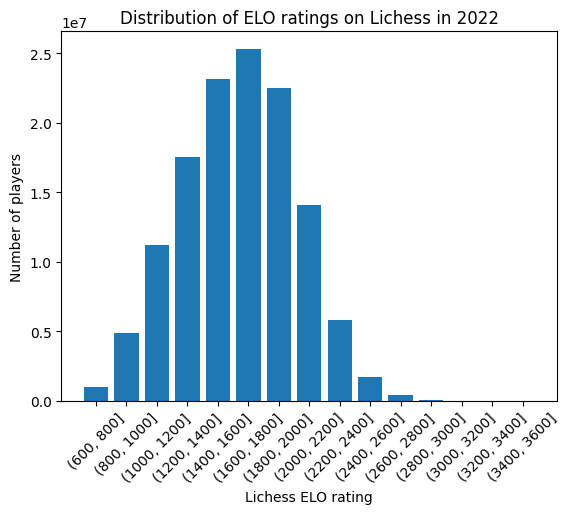

In [52]:
# Plot a graph to show the distribution of ELO ratings.
plt.bar(merged_elo_counts.index.astype(str), merged_elo_counts.values)
plt.title("Distribution of ELO ratings on Lichess in 2022")
plt.xlabel("Lichess ELO rating")
plt.ylabel("Number of players")
plt.xticks(rotation=45)
plt.show()
